# EDS Case Study

Explore changes in political views

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
# If we're running in Colab, set up the environment

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist
    !git clone --depth 1 https://github.com/AllenDowney/ExploratoryDataAnalysis
    %cd ExploratoryDataAnalysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import decorate

## Loading and validation


In [3]:
gss = pd.read_hdf('eds.gss.hdf5', 'gss0')
gss.shape

(64814, 105)

### Validating `polviews`

`polviews` contains responses to the [following question](https://gssdataexplorer.norc.org/projects/52787/variables/178/vshow)

> We hear a lot of talk these days about liberals and conservatives. 
I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

`values` takes a variable column and returns a series of values and their frequencies.

In [4]:
def values(series):
    """Count the values and sort.
    
    series: pd.Series
    
    returns: series mapping from values to frequencies
    """
    return series.value_counts().sort_index()

Here's the distribution of values for `polviews`

In [5]:
values(gss['polviews'])

1.0     1699
2.0     6299
3.0     6981
4.0    21444
5.0     8864
6.0     8495
7.0     1770
Name: polviews, dtype: int64

If we select only records from 1974, we can compare the values to the table in the codebook.

In [6]:
gss74 = gss['year']==1974
gss74.sum()

1484

The following values are consistent with the codebook, which confirms that we are reading the right variable and interpreting it correctly.

In [7]:
polviews74 = gss.loc[gss74, 'polviews']
values(polviews74)

1.0     31
2.0    201
3.0    211
4.0    538
5.0    223
6.0    181
7.0     30
Name: polviews, dtype: int64

Let's compare the results from 1974 and 2018.

In [8]:
gss18 = gss['year'] == 2018
polviews18 = gss.loc[gss18, 'polviews']

Here are the two distributions plotted side by side.  I use the `Pmf` class from `empiricaldist` to compute the probability mass functions (PMFs).

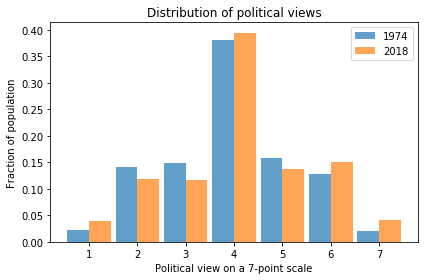

In [9]:
from empiricaldist import Pmf

Pmf.from_seq(polviews74).bar(label='1974', width=-0.45, align='edge', alpha=0.7)
Pmf.from_seq(polviews18).bar(label='2018', width=0.45, align='edge', alpha=0.7)

decorate(xlabel='Political view on a 7-point scale',
         ylabel='Fraction of population',
         title='Distribution of political views')

### Mean and standard deviation

To see how the distribution changes over time, we can group by year and compute the mean of `polviews` during each year.

In [10]:
by_year = gss.groupby('year')
by_year

Here's what the plot looks like.

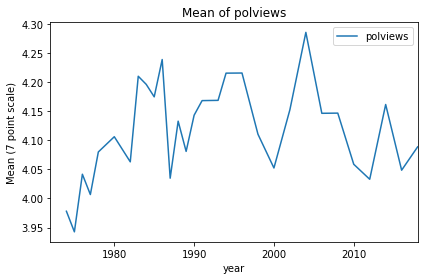

In [11]:
series = by_year['polviews'].mean()
series.plot(label='polviews')
decorate(ylabel='Mean (7 point scale)',
         title='Mean of polviews')

The standard deviation quantifies the spread of the distribution, which is one way to measure polarization.

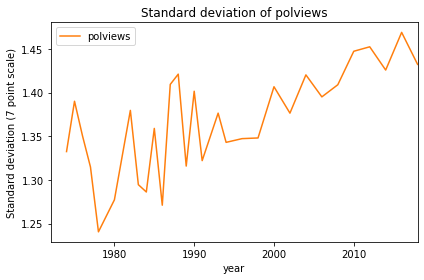

In [12]:
series = by_year['polviews'].std()
series.plot(color='C1', label='polviews')
decorate(ylabel='Standard deviation (7 point scale)',
         title='Standard deviation of polviews')

Both plots are quite noisy.

### Local regression

We can use local regression to compute a smooth line through these data points.

In [13]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def make_lowess(series):
    """Use LOWESS to compute a smooth line.
    
    series: pd.Series
    
    returns: pd.Series
    """
    endog = series.values
    exog = series.index.values

    smooth = lowess(endog, exog)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index) 

We'll use the following function to plot data points and the smoothed line.

In [14]:
def plot_series_lowess(series, color):
    """Plots a series of data points and a smooth line.
    
    series: pd.Series
    color: string or tuple
    """
    series.plot(lw=0, marker='o', color=color, alpha=0.5)
    smooth = make_lowess(series)
    smooth.plot(label='_', color=color)

`colors` is a dictionary that maps from column name to color, using conventional colors for conservatives and liberals.

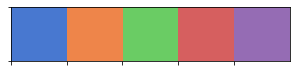

In [15]:
palette = sns.color_palette('muted', 5)
sns.palplot(palette)

In [16]:
colors = {'Conservative': palette[3], 
              'Moderate': palette[4], 
               'Liberal': palette[0]}

The following figure shows the mean of `polviews` and a smooth line.

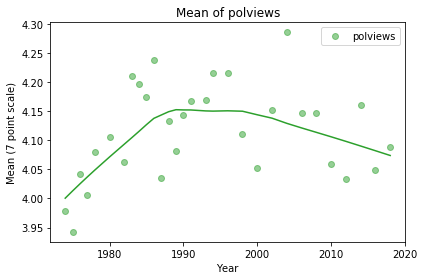

In [17]:
series = by_year['polviews'].mean()
plot_series_lowess(series, 'C2')
decorate(ylabel='Mean (7 point scale)',
         title='Mean of polviews',
         xlabel='Year',
         xlim=[1972, 2020])

And here's the standard deviation of `polviews` with a smooth line.

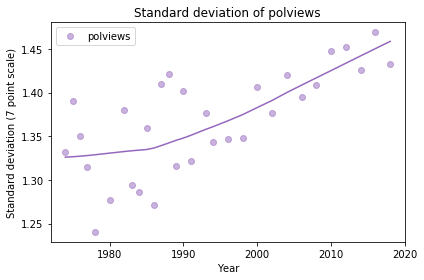

In [18]:
series = by_year['polviews'].std()
plot_series_lowess(series, color='C4')
decorate(ylabel='Standard deviation (7 point scale)',
         title='Standard deviation of polviews',
         xlabel='Year',
         xlim=[1972, 2020])

### Categorical data

In the previous sections, we treated `polviews` as a numeric quantity, but it's really categorical.  So let's see what we can do with it as a categorical variable.

In [19]:
# recode the 7 point scale with words
d = {1:'Extremely liberal', 
     2:'Liberal', 
     3:'Slightly liberal', 
     4:'Moderate', 
     5:'Slightly conservative', 
     6:'Conservative', 
     7:'Extremely conservative'}

gss['polviews7'] = gss.polviews.replace(d)
values(gss['polviews7'])

Conservative               8495
Extremely conservative     1770
Extremely liberal          1699
Liberal                    6299
Moderate                  21444
Slightly conservative      8864
Slightly liberal           6981
Name: polviews7, dtype: int64

The following function computes a `DataFrame` with the number of respondents in each category for each year.

In [20]:
def count_by_year(gss, varname):
    """Groups by category and year and counts.
    
    gss: DataFrame
    varname: string variable to group by
    
    returns: DataFrame with one row per year, one column per category.
    """
    grouped = gss.groupby([varname, 'year'])
    count = grouped[varname].count().unstack(level=0)
    
    # note: the following is not ideal, because it does not
    # distinguish 0 from NA, but in this dataset the only
    # zeros are during years when the question was not asked.
    count = count.replace(0, np.nan).dropna()
    return count

Here are the first few lines from the result.  We can compare the rows in this table with the columns in the codebook, confirming that the computation is correct, so far.

In [21]:
polviews7_count = count_by_year(gss, 'polviews7')
polviews7_count.head()

polviews7,Conservative,Extremely conservative,Extremely liberal,Liberal,Moderate,Slightly conservative,Slightly liberal
year,,,,,,,
1974,181,30,31,201,538,223,211
1975,162,45,56,184,540,204,207
1976,206,34,31,198,564,209,175
1977,164,42,37,181,594,243,214
1978,187,25,21,140,559,265,255


The number of respondents varies from year to year, so we need to "normalize", computing the fraction of respondents in each category, each year.

The following function computes the total in each row and divides through, so each row adds up to 1.

In [22]:
def normalize_by_year(df):
    """Divide each row by its total.
    
    df: DataFrame with one year per row, one category per column
    """
    # add up the elements of each row
    total = df.sum(axis=1)
    
    # divide each column by the total
    return df.div(total, axis=0)

Here's what that looking like for the 7-point scale.

In [23]:
polviews7_norm = normalize_by_year(polviews7_count)
polviews7_norm.head()

polviews7,Conservative,Extremely conservative,Extremely liberal,Liberal,Moderate,Slightly conservative,Slightly liberal
year,,,,,,,
1974,0.127915,0.021201,0.021908,0.142049,0.380212,0.157597,0.149117
1975,0.115880,0.032189,0.040057,0.131617,0.386266,0.145923,0.148069
1976,0.145378,0.023994,0.021877,0.139732,0.398024,0.147495,0.123500
1977,0.111186,0.028475,0.025085,0.122712,0.402712,0.164746,0.145085
1978,0.128788,0.017218,0.014463,0.096419,0.384986,0.182507,0.175620


The following function takes a `DataFrame` and plots the columns using `plot_series_lowess`.

In [24]:
def plot_columns_lowess(df, columns, colors):
    """Plot the columns in a DataFrame.
    
    df: pd.DataFrame
    columns: list of column names, in the desired order
    colors: mapping from column names to colors
    """
    for col in columns:
        series = df[col]
        plot_series_lowess(series, colors[col])

We can get the column names from the dictionary we used to recode.

In [25]:
columns = d.values()
columns

dict_values(['Extremely liberal', 'Liberal', 'Slightly liberal', 'Moderate', 'Slightly conservative', 'Conservative', 'Extremely conservative'])

I'll use purple for moderates and a divergent palette from blue to red for the other categories.

In [26]:
muted = sns.color_palette('muted', 5)
purple = muted[4]

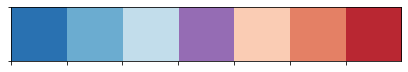

In [27]:
palette = sns.color_palette('RdBu_r', 7)
palette[3] = purple
sns.palplot(palette)

Here's the color dictionary.

In [28]:
colors = dict(zip(columns, palette))

The following function sets the position of the figure legend.

In [29]:
def anchor_legend(x, y):
    plt.legend(bbox_to_anchor=(x, y), loc='upper left', ncol=1)

Here are the 7 categories plotted as a function of time.

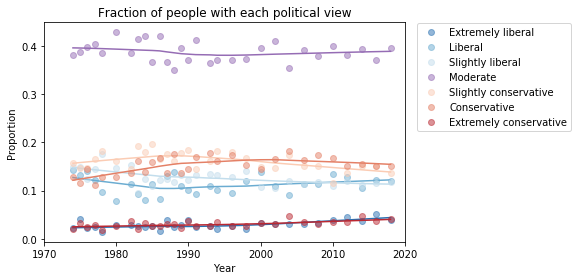

In [30]:
plot_columns_lowess(polviews7_norm, columns, colors)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Fraction of people with each political view',
         xlim=[1970, 2020])

anchor_legend(1.02, 1.02)

Here's a close look at the extremes.

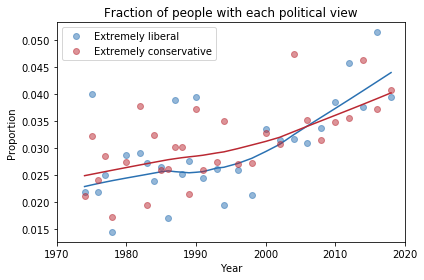

In [31]:
columns2 = ['Extremely liberal', 'Extremely conservative']

plot_columns_lowess(polviews7_norm, columns2, colors)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Fraction of people with each political view',
         xlim=[1970, 2020])

### 3-point scale

To make it easier to visualize groups, I'm going to lump the 7-point scale into a 3-point scale.

With this scale, there are roughly the same number of people in each group.

In [32]:
# replace 7 point scale with 3 point scale
d = {1:'Liberal (all)', 
     2:'Liberal (all)', 
     3:'Liberal (all)', 
     4:'Moderate', 
     5:'Conservative (all)', 
     6:'Conservative (all)', 
     7:'Conservative (all)'}

gss['polviews3'] = gss.polviews.replace(d)
values(gss['polviews3'])

Conservative (all)    19129
Liberal (all)         14979
Moderate              21444
Name: polviews3, dtype: int64

Here's the number of people in each category, over time.

In [33]:
polviews3_count = count_by_year(gss, 'polviews3')
polviews3_count.head()

polviews3,Conservative (all),Liberal (all),Moderate
year,,,
1974,434,443,538
1975,411,447,540
1976,449,404,564
1977,449,432,594
1978,477,416,559


And here are the normalize counts.

In [34]:
polviews3_norm = normalize_by_year(polviews3_count)
polviews3_norm.head()

polviews3,Conservative (all),Liberal (all),Moderate
year,,,
1974,0.306714,0.313074,0.380212
1975,0.293991,0.319742,0.386266
1976,0.316867,0.285109,0.398024
1977,0.304407,0.292881,0.402712
1978,0.328512,0.286501,0.384986


In [35]:
polviews3_norm.tail()

polviews3,Conservative (all),Liberal (all),Moderate
year,,,
2010,0.317468,0.284051,0.398481
2012,0.324109,0.294305,0.381586
2014,0.351351,0.255119,0.393530
2016,0.339376,0.290428,0.370196
2018,0.329495,0.275908,0.394597


Here's the color dictionary.

In [36]:
colors = {'Conservative (all)': muted[3], 
          'Moderate': muted[4], 
          'Liberal (all)': muted[0]}

The following plot shows the fraction of respondents in each category over time.

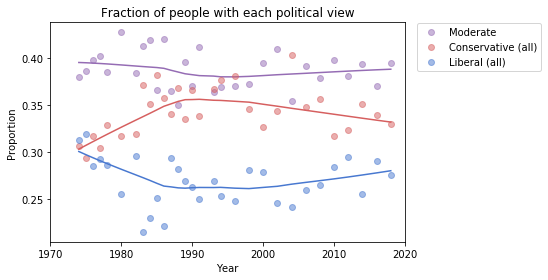

In [37]:
columns = ['Moderate', 'Conservative (all)', 'Liberal (all)']
plot_columns_lowess(polviews3_norm, columns, colors)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Fraction of people with each political view',
         xlim=[1970, 2020])

anchor_legend(1.02, 1.02)